# Anisotropy in 2D

This tutorial demonstrates how fiber rotation affects the speed of the wave in
different directions.

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw


# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
out = []
images = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[..., 0] = np.cos(alpha)
    tissue.fibers[..., 1] = np.sin(alpha)

    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                 n//2 - 5, n//2 + 5))
    
    # create model object and set up parameters
    aliev_panfilov = fw.AlievPanfilov2D()
    aliev_panfilov.dt = 0.01
    aliev_panfilov.dr = 0.25
    aliev_panfilov.t_max = 25
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()
    
    # calculate properties of the wave
    labeled = (aliev_panfilov.u > 0.1).astype(int)
    props = ski.measure.regionprops_table(labeled, properties=(
        'orientation', 'major_axis_length', 'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images.append(aliev_panfilov.u.copy())

    out.append(pd.DataFrame(props))

out = pd.concat(out)

Running AlievPanfilov2D: 100%|█████████▉| 2499/2500 [00:03<00:00, 785.35it/s]


### Show the Wave Anisotropy and Properties

This section demonstrates the anisotropy of the wave and its properties, including orientation, major and minor axis lengths, axis ratio, and density calculation. The wave propagation is simulated for different fiber orientations (alpha values) in a 2D cardiac tissue model.

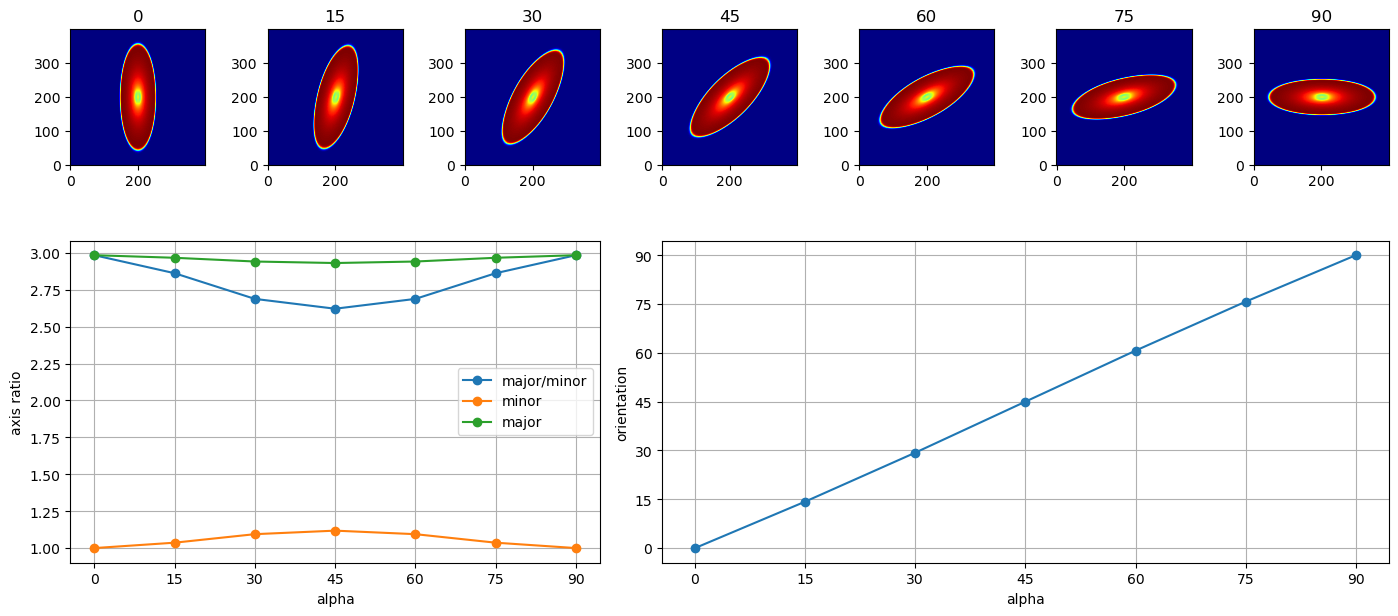

In [6]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 3 + ['orientation']*4],
                               figsize=(14, 7))

for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images[i], cmap='jet', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

ax = axs['axis_ratio']
ax.plot(out['alpha'], out['axis_ratio'], 'o-', label='major/minor')
ax.plot(out['alpha'],
        out['minor_axis_length'] / out['minor_axis_length'].min(),
        'o-', label='minor')
ax.plot(out['alpha'],
        out['major_axis_length'] / out['minor_axis_length'].min(),
        'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

ax = axs['orientation']
ax.plot(out['alpha'], out['orientation'], 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

## Effect of Fibrosis on Anisotropy

This section explores the impact of fibrosis on the anisotropy of wave propagation in cardiac tissue. By introducing fibrosis into the tissue model, we can observe changes in wave speed and directionality. The simulations are performed for different fiber orientations (alpha values), and the resulting wave properties, such as orientation, axis lengths, and axis ratios, are analyzed to understand the effects of fibrosis on anisotropy.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 400

alphas = np.radians(np.arange(0, 91, 15))
d = 0.2
out_fib = []
images_fib = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    tissue.add_pattern(fw.Diffuse2DPattern(d))
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[..., 0] = np.cos(alpha)
    tissue.fibers[..., 1] = np.sin(alpha)

    # set up stimulation parameters:
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(fw.StimVoltageCoord2D(0, 1, n//2 - 5, n//2 + 5,
                                                 n//2 - 5, n//2 + 5))
    
    # create model object:
    aliev_panfilov = fw.AlievPanfilov2D()
    # set up numerical parameters:
    aliev_panfilov.dt = 0.01
    aliev_panfilov.dr = 0.25
    aliev_panfilov.t_max = 30
    aliev_panfilov.cardiac_tissue = tissue
    aliev_panfilov.stim_sequence = stim_sequence

    aliev_panfilov.run()

    labeled = (aliev_panfilov.u > 0.5).astype(int)
    props = ski.measure.regionprops_table(
        labeled, properties=('orientation', 'major_axis_length',
                             'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images_fib.append(aliev_panfilov.u.copy())

    out_fib.append(pd.DataFrame(props))

out_fib = pd.concat(out_fib)

Running AlievPanfilov2D: 100%|█████████▉| 2999/3000 [00:03<00:00, 841.94it/s]


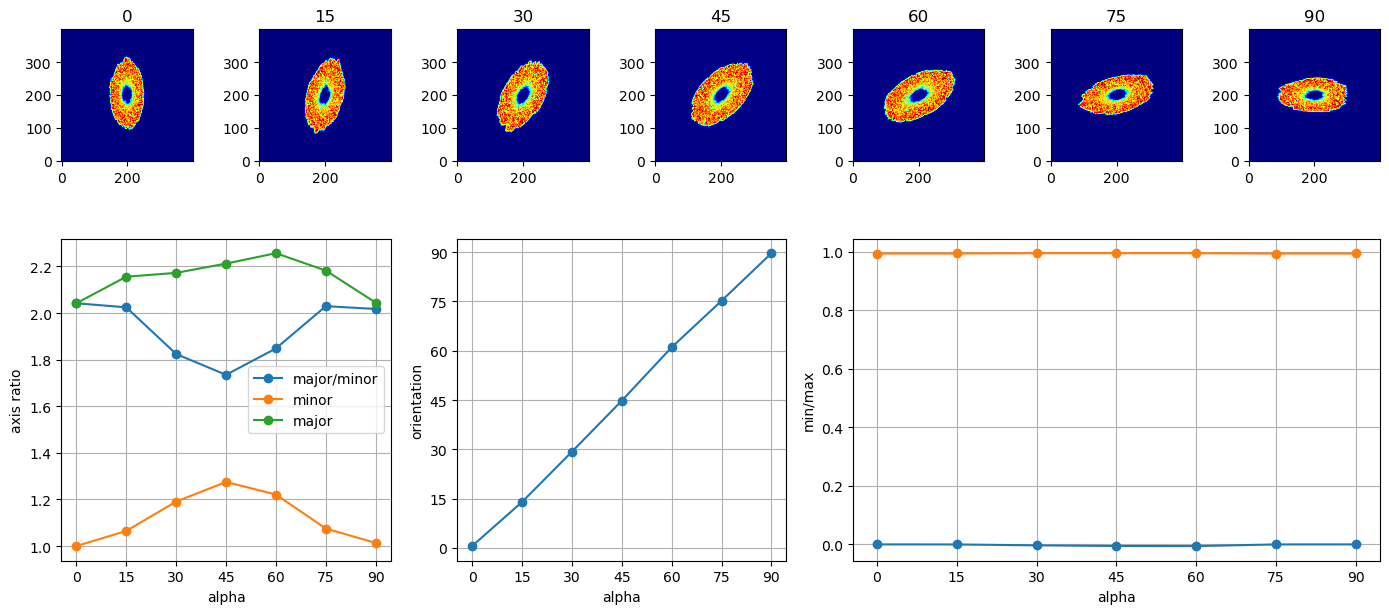

In [5]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 2 + ['orientation']*2 +
                               ['min_max'] * 3],
                               figsize=(14, 7))

mins = []
maxs = []
for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images_fib[i], cmap='jet', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

    mins.append(images_fib[i].min())
    maxs.append(images_fib[i].max())
    

ax = axs['axis_ratio']
ax.plot(out_fib['alpha'],
        out_fib['axis_ratio'], 'o-', label='major/minor')
ax.plot(out_fib['alpha'],
        out_fib['minor_axis_length'] /out_fib['minor_axis_length'].min(),
        'o-', label='minor')
ax.plot(out_fib['alpha'],
        out_fib['major_axis_length'] / out_fib['minor_axis_length'].min(), 
        'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

out_fib.loc[out_fib['orientation'] < 0, 'orientation'] += 180

orientation = out_fib['orientation'].values
orientation[orientation > 90] = 180 - orientation[orientation > 90]

ax = axs['orientation']
ax.plot(out_fib['alpha'], orientation, 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

ax = axs['min_max']
ax.plot(np.degrees(alphas), mins, 'o-', label='min')
ax.plot(np.degrees(alphas), maxs, 'o-', label='max')
ax.set_xlabel('alpha')
ax.set_ylabel('min/max')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

## Using Luo Rudy (1991) Model

When using ionic model using smaller step (compared to the calculation without fibers) can be nessesary otherwise the calculation can be unstable.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import pandas as pd

import finitewave as fw

# number of nodes on the side
n = 256
dt = 0.005
dr = 0.1
t_max = 10

alphas = np.radians(np.arange(0, 91, 15))
d = 0.2
out_lr_fib = []
images_lr_fib = []
for alpha in alphas:
    tissue = fw.CardiacTissue2D([n, n])
    # tissue.add_pattern(fw.Diffuse2DPattern(d))
    # add fibers orientation vectors
    tissue.fibers = np.zeros([n, n, 2])
    tissue.fibers[..., 0] = np.cos(alpha)
    tissue.fibers[..., 1] = np.sin(alpha)

    # set up stimulation parameters:
    stim = fw.StimCurrentArea2D(0, 50, 1)
    stim.add_stim_point([n//2, n//2], tissue.mesh, 5)
    stim_sequence = fw.StimSequence()
    stim_sequence.add_stim(stim)

    # create model object:
    model = fw.TP062D()
    # set up numerical parameters:
    model.dt = dt
    model.dr = dr
    model.t_max = t_max
    model.cardiac_tissue = tissue
    model.stim_sequence = stim_sequence

    model.run()

    labeled = (model.u > 0.).astype(int)
    props = ski.measure.regionprops_table(
        labeled, properties=('orientation', 'major_axis_length',
                             'minor_axis_length'))
    props['orientation'] = np.degrees(props['orientation'])
    props['axis_ratio'] = props['major_axis_length'] / props['minor_axis_length']
    props['alpha'] = np.degrees(alpha)
    props['density_calc'] = (np.sum(tissue.mesh[-1:1, -1:1] == 2) 
                                / ((n - 2) * (n - 2)))
    images_lr_fib.append(model.u.copy())

    out_lr_fib.append(pd.DataFrame(props))

out_lr_fib = pd.concat(out_lr_fib)

Running LuoRudy912D:   0%|          | 0/2000 [00:00<?, ?it/s]

Running LuoRudy912D: 100%|█████████▉| 1999/2000 [00:05<00:00, 339.81it/s]


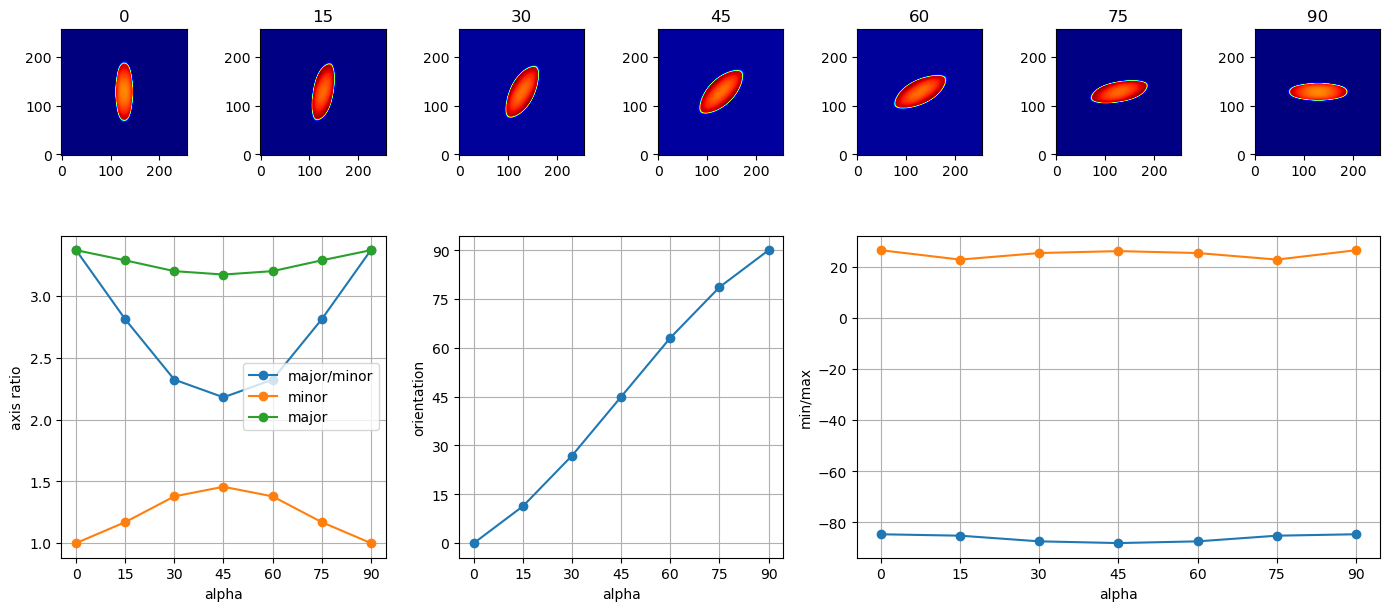

In [52]:

fig, axs = plt.subplot_mosaic([[f'{i}' for i in range(7)],
                               ['axis_ratio'] * 2 + ['orientation']*2 +
                               ['min_max'] * 3],
                               figsize=(14, 7))

mins = []
maxs = []
for i in range(len(alphas)):
    ax = axs[f'{i}']
    ax.imshow(images_lr_fib[i], cmap='jet', origin='lower')
    ax.set_title(f'{np.degrees(alphas[i]):.0f}')

    mins.append(images_lr_fib[i].min())
    maxs.append(images_lr_fib[i].max())
    

ax = axs['axis_ratio']
ax.plot(out_lr_fib['alpha'],
        out_lr_fib['axis_ratio'], 'o-', label='major/minor')
ax.plot(out_lr_fib['alpha'],
        out_lr_fib['minor_axis_length'] /out_lr_fib['minor_axis_length'].min(),
        'o-', label='minor')
ax.plot(out_lr_fib['alpha'],
        out_lr_fib['major_axis_length'] / out_lr_fib['minor_axis_length'].min(), 
        'o-', label='major')
ax.set_xlabel('alpha')
ax.set_ylabel('axis ratio')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)
ax.legend()

out_lr_fib.loc[out_lr_fib['orientation'] < 0, 'orientation'] += 180

orientation = out_lr_fib['orientation'].values
orientation[orientation > 90] = 180 - orientation[orientation > 90]

ax = axs['orientation']
ax.plot(out_lr_fib['alpha'], orientation, 'o-')
ax.set_xlabel('alpha')
ax.set_ylabel('orientation')
ax.set_xticks(np.degrees(alphas))
ax.set_yticks(np.degrees(alphas))
ax.grid(True)

ax = axs['min_max']
ax.plot(np.degrees(alphas), mins, 'o-', label='min')
ax.plot(np.degrees(alphas), maxs, 'o-', label='max')
ax.set_xlabel('alpha')
ax.set_ylabel('min/max')
ax.set_xticks(np.degrees(alphas))
ax.grid(True)

plt.tight_layout()
plt.show()

Running LuoRudy912D:   0%|          | 0/4000 [00:00<?, ?it/s]

Running LuoRudy912D: 100%|█████████▉| 3999/4000 [00:13<00:00, 300.92it/s]


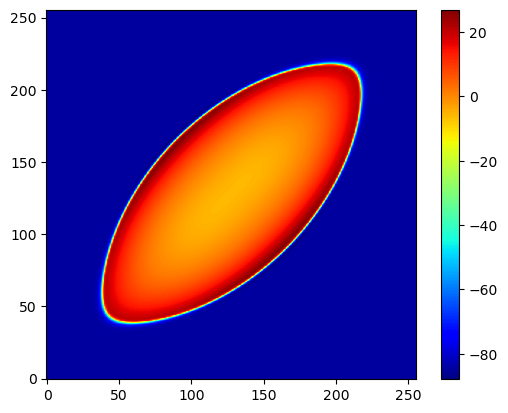

In [46]:
n = 256
d = 0.2
t_max = 20
dt = 0.005
dr = 0.1
alpha = np.radians(45)
tissue = fw.CardiacTissue2D([n, n])
# tissue.add_pattern(fw.Diffuse2DPattern(d))
# add fibers orientation vectors
tissue.fibers = np.zeros([n, n, 2])
tissue.fibers[..., 0] = np.cos(alpha)
tissue.fibers[..., 1] = np.sin(alpha)

# set up stimulation parameters:
stim = fw.StimCurrentArea2D(0, 50, 1)
stim.add_stim_point([n//2, n//2], tissue.mesh, 5)
stim_sequence = fw.StimSequence()
stim_sequence.add_stim(stim)

# create model object:
model = fw.LuoRudy912D()
# set up numerical parameters:
model.dt = dt
model.dr = dr
model.t_max = t_max
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence

model.run()

plt.figure()
plt.imshow(model.u, cmap='jet', origin='lower')
plt.colorbar()
plt.show()